In [1]:
import pandas as pd
import json
import time
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm for the progress bar
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, classification_report
import seaborn as sns
import numpy as np

# Evaluate Multi-Class


## Load file with predictions

In [2]:
prompt_ids_to_eval = ["P1", "P2", "P3", "P4"] #, "P2", "P3", "P4"
model = "gpt-3.5-turbo"

In [3]:
# Create the list of prediction columns based on the prompt IDs
prediction_columns = [f'gpt_predictions_{prompt_id}' for prompt_id in prompt_ids_to_eval]
# Specify the basic columns to include in the DataFrame
basic_columns = ['pmid', 'accepted_label', 'multi_label', 'binary_label']
# Combine basic columns with the dynamically generated prediction columns
columns_to_read = basic_columns + prediction_columns

In [4]:
sampled_df = pd.read_csv(f"predictions/{model}_outputs_{'_'.join(prompt_ids_to_eval)}.csv")[columns_to_read]

In [5]:
sampled_df.shape

(50, 8)

In [6]:
sampled_df.head()

,pmid,accepted_label,multi_label,binary_label,gpt_predictions_P1,gpt_predictions_P2,gpt_predictions_P3,gpt_predictions_P4
0,24507711,Human-RCT-non-intervention,13,0,Human-non-RCT-non-drug-intervention,Human-non-RCT-non-drug-intervention,Clinical-study-protocol,"Human, non-RCT non-drug-intervention"
1,28684367,Human-case-report,4,0,Human-case-report,Human-case-report,Human-case-report,Case report
2,2840539,Animal-other,5,1,Animal-drug-intervention,Animal-drug-intervention,Animal-other,"Animal, other"
3,35332187,Remaining,0,0,Human-systematic-review,Human-systematic-review,Human-systematic-review,"Human, systematic review"
4,26582408,Clinical-study-protocol,12,0,Clinical-study-protocol,Clinical-study-protocol,Clinical-study-protocol,Study protocol


## Map predictions to numerical

In [7]:
label_to_numerical = {
    'Remaining': 0,
    'Non-systematic-review': 1,
    'Human-non-RCT-non-drug-intervention': 2,
    'Human-non-RCT-drug-intervention': 3,
    'Human-case-report': 4,
    'Animal-other': 5,
    'Animal-drug-intervention': 6,
    'Human-systematic-review': 7,
    'In-vitro-study': 8,
    'Human-RCT-non-drug-intervention': 9,
    'Animal-non-drug-intervention': 10,
    'Human-RCT-drug-intervention': 11,
    'Clinical-study-protocol': 12,
    'Human-RCT-non-intervention': 13
}

In [10]:
numerical_to_label = {v: f"{v} - {k}" for k, v in label_to_numerical.items()}


In [11]:
import difflib

def map_label_fuzzy(label, label_dict):
    #label = label.lower().replace('-', '').replace('_', ' ').strip()
    best_match = difflib.get_close_matches(label, label_dict.keys(), n=1, cutoff=0.6)
    if best_match:
        #print(f'{label} matched to {best_match[0]}')
        return label_dict[best_match[0]]
    return -1

In [12]:
map_label_fuzzy("RCT-drug-intervention", label_to_numerical)

11

In [13]:
def map_label_to_numerical(label, label_dict):
    # Check if label is a dictionary
    if isinstance(label, dict):
        # Extract the label with the highest score/probability
        highest_label = max(normalized_label, key=label.get)
        return label_dict.get(highest_label, -1)
    else:
         # Normalize label
        normalized_label = label.replace(',', '').strip().replace(' ', '-')#.strip()
        # Directly map string labels to numerical IDs
        numerical_label = label_dict.get(label, -1)
        # Fuzzy match if no direct mapping possible
        if numerical_label == -1:
            numerical_label = map_label_fuzzy(normalized_label, label_dict)
        return numerical_label
        
# Convert accepted labels to numerical
sampled_df['accepted_label_numerical'] = sampled_df['accepted_label'].apply(lambda x: map_label_to_numerical(x, label_to_numerical))


for col in prediction_columns:
    sampled_df[f'{col}_numerical'] = sampled_df[col].apply(lambda x: map_label_to_numerical(x, label_to_numerical))

sampled_df.head()

,pmid,accepted_label,multi_label,binary_label,gpt_predictions_P1,gpt_predictions_P2,gpt_predictions_P3,gpt_predictions_P4,accepted_label_numerical,gpt_predictions_P1_numerical,gpt_predictions_P2_numerical,gpt_predictions_P3_numerical,gpt_predictions_P4_numerical
0,24507711,Human-RCT-non-intervention,13,0,Human-non-RCT-non-drug-intervention,Human-non-RCT-non-drug-intervention,Clinical-study-protocol,"Human, non-RCT non-drug-intervention",13,2,2,12,2
1,28684367,Human-case-report,4,0,Human-case-report,Human-case-report,Human-case-report,Case report,4,4,4,4,4
2,2840539,Animal-other,5,1,Animal-drug-intervention,Animal-drug-intervention,Animal-other,"Animal, other",5,6,6,5,5
3,35332187,Remaining,0,0,Human-systematic-review,Human-systematic-review,Human-systematic-review,"Human, systematic review",0,7,7,7,7
4,26582408,Clinical-study-protocol,12,0,Clinical-study-protocol,Clinical-study-protocol,Clinical-study-protocol,Study protocol,12,12,12,12,12


#### Important: some labels from GPT could not be mapped to a target label

In [14]:
rows_with_minus_one = sampled_df[(sampled_df == -1).any(axis=1)]
rows_with_minus_one

,pmid,accepted_label,multi_label,binary_label,gpt_predictions_P1,gpt_predictions_P2,gpt_predictions_P3,gpt_predictions_P4,accepted_label_numerical,gpt_predictions_P1_numerical,gpt_predictions_P2_numerical,gpt_predictions_P3_numerical,gpt_predictions_P4_numerical
8,21922877,Human-RCT-non-drug-intervention,9,0,Human-RCT-drug-intervention,{'journal': 'Tropical gastroenterology : offic...,Human-RCT-drug-intervention,RCT non-drug-intervention,9,11,-1,11,9


## Evaluate prompts

In [17]:
def evaluate_predictions(df, target_label_col, prompt_ids_to_eval, model, eval_type, label_to_numerical, numerical_to_label):
    report_dfs = []
    summary_stats = []

    for prompt_id in prompt_ids_to_eval:
        print("Evaluating ", prompt_id)
        prediction_col = f'gpt_predictions_{prompt_id}'

        # Extract arrays for evaluation
        y_true = df[target_label_col].values
        y_pred = df[f'{prediction_col}_numerical'].values
        cm = confusion_matrix(y_true, y_pred, labels=range(len(label_to_numerical)))
        
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred)
        accuracy_balanced = balanced_accuracy_score(y_true, y_pred)
        report = classification_report(y_true, y_pred, output_dict=True, zero_division=0, labels=range(len(label_to_numerical)), target_names=[numerical_to_label[i] for i in range(len(label_to_numerical))])

        
        # Create DataFrame from report
        report_df = pd.DataFrame(report).transpose()
        report_df['Prompt ID'] = prompt_id
        report_dfs.append(report_df)
        
        # Extract summary statistics
        summary = report_df.loc['weighted avg', ['precision', 'recall', 'f1-score']].to_dict()
        summary['Prompt ID'] = prompt_id
        summary_stats.append(summary)

        # Plotting confusion matrix
        plt.figure(figsize=(10, 6))
        ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(len(label_to_numerical)), yticklabels=range(len(label_to_numerical)))
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=13)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=13)
        plt.title(f'Confusion Matrix for Model {model} and Prompt {prompt_id}', fontsize=14)
        plt.xlabel('Predicted Labels', fontsize=13)
        plt.ylabel('True Labels', fontsize=13)

        # Add an inset with label mapping
        textstr = '\n'.join([f'{v}: {k}' for k, v in label_to_numerical.items()])
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.text(1.16, 1.0, textstr, transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=props)
        plt.tight_layout()
        plt.savefig(f'plots/confusion_matrix_{model}_{prompt_id}_{eval_type}.pdf')  # Save to PDF

    # Combine all report DataFrames
    all_reports_df = pd.concat(report_dfs)

    # Create a summary table for average precision, recall, and F1-score
    summary_df = pd.DataFrame(summary_stats)
    # Save results to CSV files
    all_reports_df.to_csv(f"evaluations/{model}_per_class_{'_'.join(prompt_ids_to_eval)}_{eval_type}.csv")
    summary_df.to_csv(f"evaluations/{model}_summary_{'_'.join(prompt_ids_to_eval)}_{eval_type}.csv")

    print("Results saved to evaluations/ and plots/ folders.")

    return all_reports_df, summary_df


Evaluating  P1
Evaluating  P2


/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Evaluating  P3
Evaluating  P4


/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/anaconda3/envs/studytype-teller/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Results saved to evaluations/ and plots/ folders.


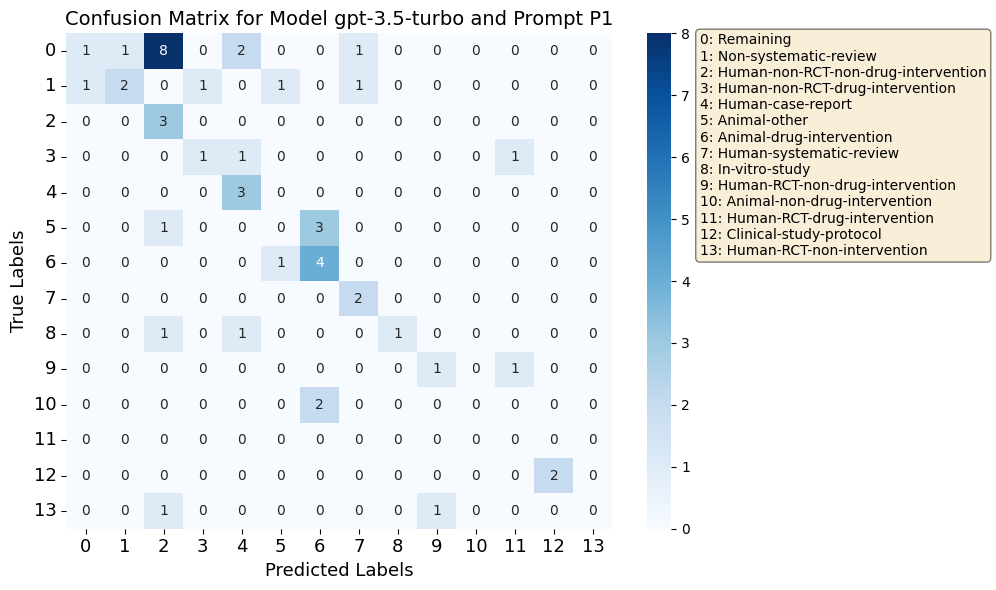

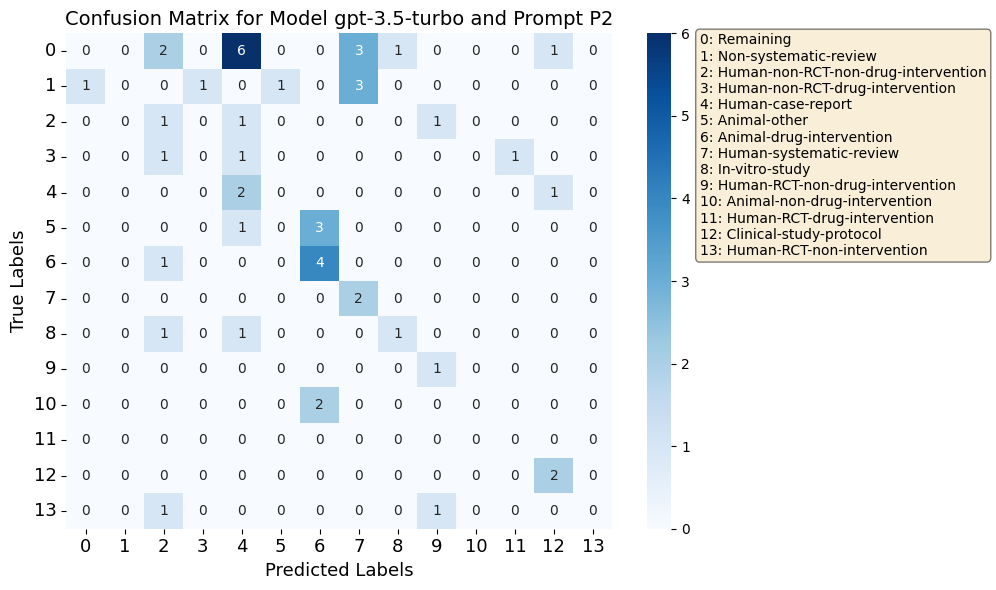

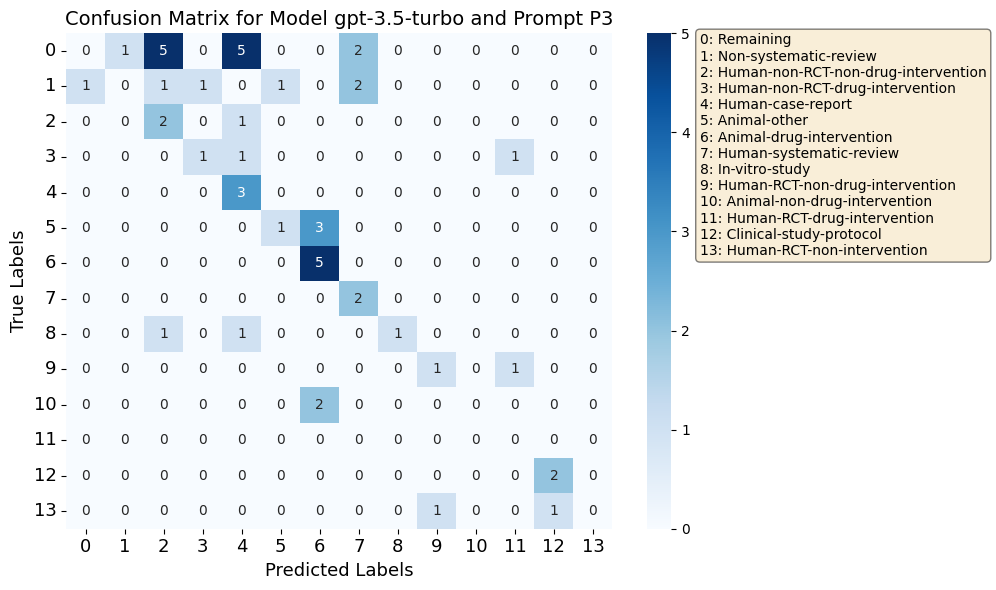

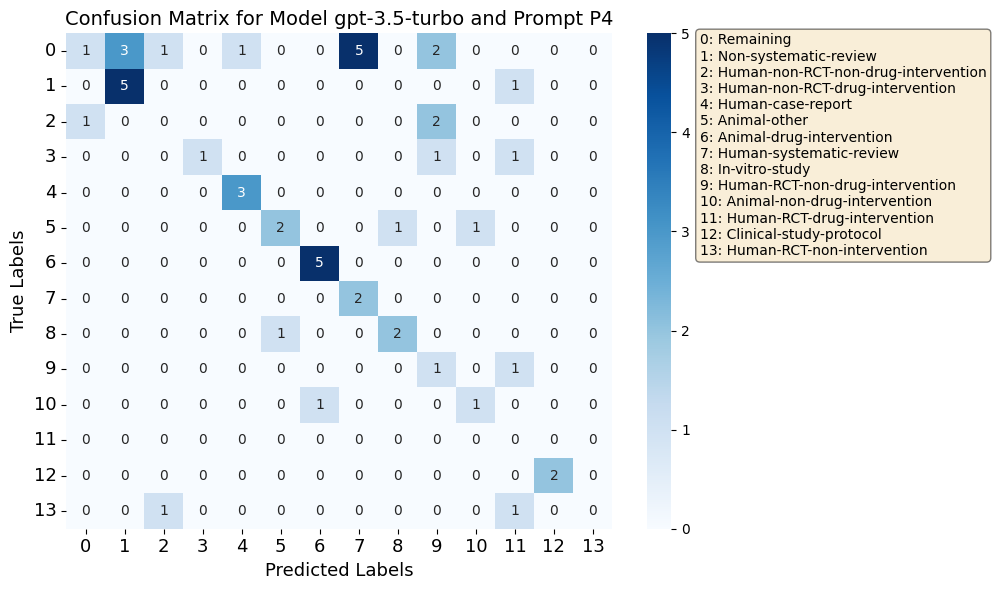

In [18]:
target_label_col = 'accepted_label_numerical'
eval_type = 'multi_label'
all_reports_df, summary_df = evaluate_predictions(sampled_df, target_label_col, prompt_ids_to_eval, model, eval_type, label_to_numerical, numerical_to_label)


In [19]:
summary_df

,precision,recall,f1-score,Prompt ID
0,0.463016,0.40,0.342986,P1
1,0.136349,0.26,0.167810,P2
2,0.269697,0.36,0.265048,P3
3,0.564762,0.50,0.466211,P4


In [20]:
all_reports_df

,precision,recall,f1-score,support,Prompt ID
0 - Remaining,0.500000,0.076923,0.133333,13.0,P1
1 - Non-systematic-review,0.666667,0.333333,0.444444,6.0,P1
2 - Human-non-RCT-non-drug-intervention,0.214286,1.000000,0.352941,3.0,P1
3 - Human-non-RCT-drug-intervention,0.500000,0.333333,0.400000,3.0,P1
4 - Human-case-report,0.428571,1.000000,0.600000,3.0,P1
...,...,...,...,...,...
12 - Clinical-study-protocol,1.000000,1.000000,1.000000,2.0,P4
13 - Human-RCT-non-intervention,0.000000,0.000000,0.000000,2.0,P4
accuracy,0.500000,0.500000,0.500000,0.5,P4
macro avg,0.499575,0.529304,0.467599,50.0,P4


# Evaluate Binary

## Load file with predictions

In [21]:
prompt_ids_to_eval = ["P1", "P2", "P3"] #, "P2", "P3", "P4"
model = "gpt-3.5-turbo"

In [22]:
# Create the list of prediction columns based on the prompt IDs
prediction_columns = [f'gpt_predictions_{prompt_id}' for prompt_id in prompt_ids_to_eval]
# Specify the basic columns to include in the DataFrame
basic_columns = ['pmid', 'accepted_label', 'multi_label', 'binary_label']
# Combine basic columns with the dynamically generated prediction columns
columns_to_read = basic_columns + prediction_columns

In [221]:
target_file_for_eval = f"predictions/{model}_outputs_{'_'.join(prompt_ids_to_eval)}_binary.csv"
df_binary = pd.read_csv(target_file_for_eval)[columns_to_read]

## Map to numerical

In [228]:
label_to_numerical_binary= {
    'OTHER': 0,
    'ANIMAL': 1,
}
numerical_to_label_binary = {v: f"{v} - {k}" for k, v in label_to_numerical_binary.items()}


In [229]:
for col in prediction_columns:
    df_binary[f'{col}_numerical'] = df_binary[col].apply(lambda x: map_label_to_numerical(x, label_to_numerical_binary))

In [230]:
df_binary.head()

,pmid,accepted_label,multi_label,binary_label,gpt_predictions_P1,gpt_predictions_P2,gpt_predictions_P3,gpt_predictions_P1_numerical,gpt_predictions_P2_numerical,gpt_predictions_P3_numerical
0,24507711,Human-RCT-non-intervention,13,0,OTHER,OTHER,OTHER,0,0,0
1,28684367,Human-case-report,4,0,OTHER,OTHER,OTHER,0,0,0
2,2840539,Animal-other,5,1,OTHER,OTHER,OTHER,0,0,0
3,35332187,Remaining,0,0,OTHER,OTHER,OTHER,0,0,0
4,26582408,Clinical-study-protocol,12,0,OTHER,OTHER,OTHER,0,0,0


In [231]:
rows_with_minus_one = df_binary[(df_binary == -1).any(axis=1)]
rows_with_minus_one

,pmid,accepted_label,multi_label,binary_label,gpt_predictions_P1,gpt_predictions_P2,gpt_predictions_P3,gpt_predictions_P1_numerical,gpt_predictions_P2_numerical,gpt_predictions_P3_numerical


## Evaluate

Evaluating  P1
Evaluating  P2
Evaluating  P3


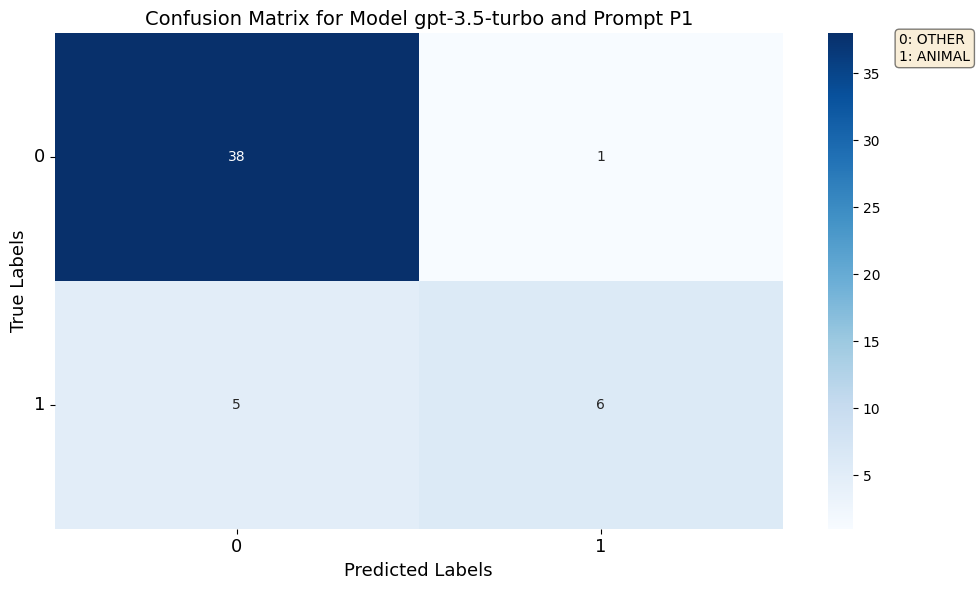

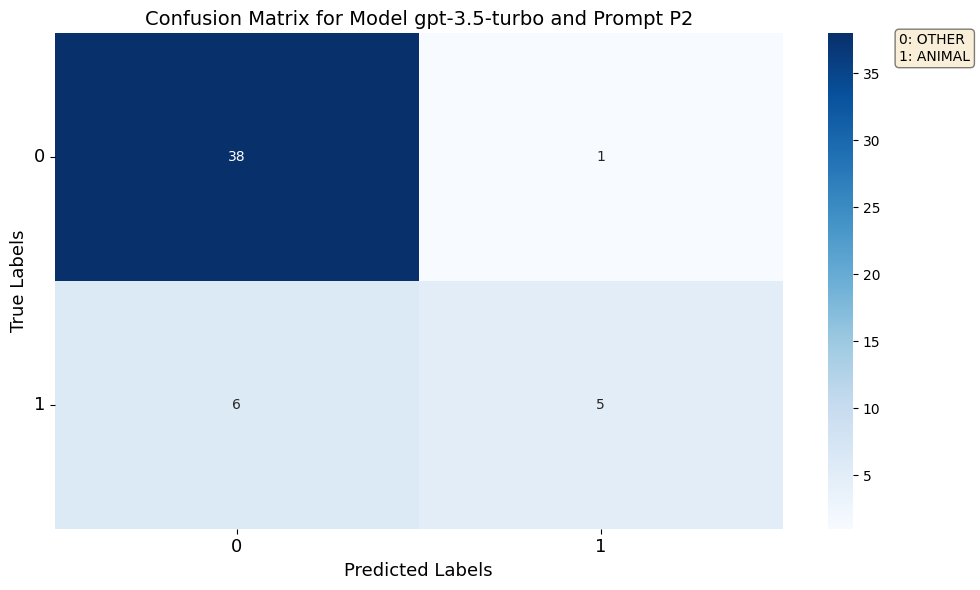

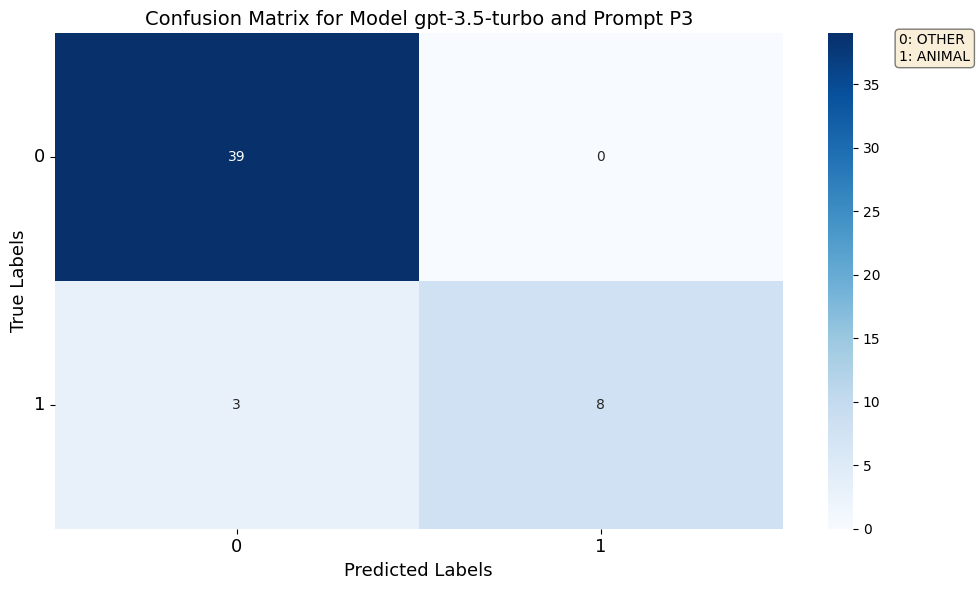

In [233]:
target_label_col = 'binary_label'
eval_type = 'binary_label'
all_reports_df, summary_df = evaluate_predictions(df_binary, target_label_col, prompt_ids_to_eval, model, eval_type, label_to_numerical_binary, numerical_to_label_binary)


In [234]:
all_reports_df

,precision,recall,f1-score,support,Prompt ID
0 - OTHER,0.883721,0.974359,0.926829,39.00,P1
1 - ANIMAL,0.857143,0.545455,0.666667,11.00,P1
accuracy,0.880000,0.880000,0.880000,0.88,P1
macro avg,0.870432,0.759907,0.796748,50.00,P1
weighted avg,0.877874,0.880000,0.869593,50.00,P1
0 - OTHER,0.863636,0.974359,0.915663,39.00,P2
1 - ANIMAL,0.833333,0.454545,0.588235,11.00,P2
accuracy,0.860000,0.860000,0.860000,0.86,P2
macro avg,0.848485,0.714452,0.751949,50.00,P2
weighted avg,0.856970,0.860000,0.843629,50.00,P2
